# Long-Short Term Memory Neural Networks for Time Series Forecasting.

In [252]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import metalib as mtl
import MetaTrader5 as mt5
import mplfinance as mpl
import matplotlib.pyplot as plt
import ta
from tqdm import tqdm


## Data extraction

we would try to predict the OHLC prices of the USDJPY instrument for the next 8 hours using the previous 250 hours sequence, training the model with the past 5000 hours.

In [253]:
future = 9
past = 5000
unseen_ticks = 250
INSTRUMENT = 'USDJPY'
TIME_FRAME = 'H1'
data = mtl.get_nbars(INSTRUMENT, TIME_FRAME, unseen_ticks, past).drop(['spread','real_volume'], axis=1).set_index('time')
unseen_data = mtl.get_nbars(INSTRUMENT, TIME_FRAME, 0, unseen_ticks).drop(['spread','real_volume'], axis=1).set_index('time')

print('training data shape: ', data.shape)
print('unseen data shape: ', unseen_data.shape)

training data shape:  (5000, 5)
unseen data shape:  (250, 5)


In [254]:
data.tail()

,open,high,low,close,tick_volume
time,,,,,
2023-03-30 18:00:00,132.700,132.754,132.590,132.713,6134
2023-03-30 19:00:00,132.712,132.713,132.362,132.387,4475
2023-03-30 20:00:00,132.386,132.467,132.319,132.435,4414
2023-03-30 21:00:00,132.435,132.470,132.393,132.446,3703
2023-03-30 22:00:00,132.445,132.625,132.422,132.612,2186


In [178]:
unseen_data

,open,high,low,close,tick_volume
time,,,,,
2023-03-30 17:00:00,132.675,132.889,132.614,132.700,6794
2023-03-30 18:00:00,132.700,132.754,132.590,132.713,6134
2023-03-30 19:00:00,132.712,132.713,132.362,132.387,4475
2023-03-30 20:00:00,132.386,132.467,132.319,132.435,4414
2023-03-30 21:00:00,132.435,132.470,132.393,132.446,3703
...,...,...,...,...,...
2023-04-13 22:00:00,132.761,132.782,132.704,132.727,2092
2023-04-13 23:00:00,132.727,132.744,132.568,132.570,1665
2023-04-14 00:00:00,132.564,132.572,132.480,132.563,1235


### Data Visualization:

the red candles are the ticks to predict meanwhile the black and withe ones are the data used for training:

c:\projects\MLworkspace\lib\site-packages\mplfinance\_arg_validators.py:83: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


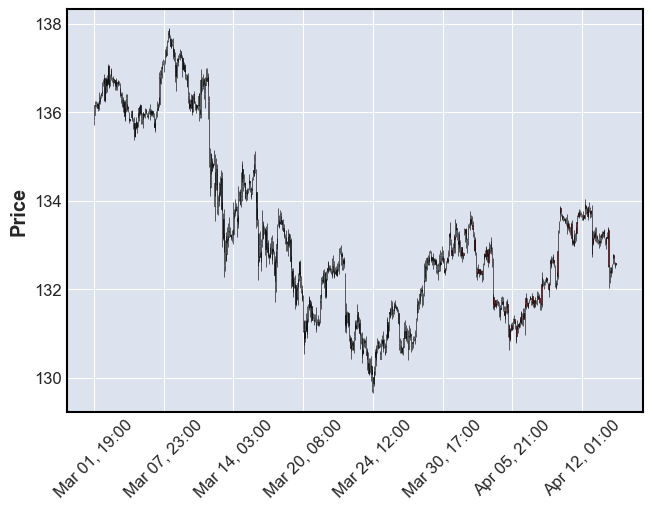

In [179]:

# plt.plot(data.time, data.close, label='training data')
# plt.plot(unseen_data.time, unseen_data.close, label='unseen data')
# plt.legend()

#creating a nan array to match both dataframes shape:
plot_ticks = 500
nan_array = np.zeros((plot_ticks, 5))
nan_array[:] = np.nan
pd.concat((pd.DataFrame(nan_array, columns=data.columns, index=data.index[-plot_ticks:]), unseen_data))

mc = mpl.make_marketcolors(up='red',down='red', edge='black')
s  = mpl.make_mpf_style(marketcolors=mc)

fig, axlist = mpl.plot(data[['open','close','high','low']][-plot_ticks:], #plotting the last 100 values since 5000 ticks are too much data.data[['open','close','high','low']][-100:]
                       type='candle',
                       returnfig = True)
mpl.plot(pd.concat((pd.DataFrame(nan_array, columns=data.columns, index=data.index[-plot_ticks:]), unseen_data))[['open','close','high','low']],
          type='candle',
          ax=axlist[0],
          style = s)


## Data preprocessing and feature engineering:

We will use the next features:
- Open, High, Low, and Close prices
- trend indicators:
    - Detrended prices oscilator (DPOIndicator)
    - Mass Index
    - TRIX indicator
    - Vortex Indicator
- volume indicators:
    - Chaikin money flow
    - Volume-price trend
    - Force Index


In [195]:


#Detrended price oscilator:
data['DPOIndicator'] = ta.trend.DPOIndicator(data.close, window=21,fillna=True).dpo()
unseen_data['DPOIndicator'] = ta.trend.DPOIndicator(unseen_data.close, window=21,fillna=True).dpo()

# #Mass_index oscilator
# data['mass_index'] = ta.trend.MassIndex(data.high, data.low, window_fast=21,fillna=True).mass_index()
# unseen_data['mass_index'] = ta.trend.MassIndex(unseen_data.high, unseen_data.low,fillna=True).mass_index()

# # TRIX_indicator:
# data['TRIX_indicator'] = ta.trend.TRIXIndicator(data.close, fillna=True).trix()
# unseen_data['TRIX_indicator'] = ta.trend.TRIXIndicator(unseen_data.close, fillna=True).trix()

#Vortex_indicator
data['vortex_indicator_diff'] = ta.trend.VortexIndicator(data.high, data.low, data.close, fillna=True).vortex_indicator_diff()
data['vortex_indicator_neg'] = ta.trend.VortexIndicator(data.high, data.low, data.close, fillna=True).vortex_indicator_neg()
data['vortex_indicator_pos'] = ta.trend.VortexIndicator(data.high, data.low, data.close, fillna=True).vortex_indicator_pos()

unseen_data['vortex_indicator_diff'] = ta.trend.VortexIndicator(unseen_data.high, unseen_data.low, unseen_data.close, fillna=True).vortex_indicator_diff()
unseen_data['vortex_indicator_neg'] = ta.trend.VortexIndicator(unseen_data.high, unseen_data.low, unseen_data.close, fillna=True).vortex_indicator_neg()
unseen_data['vortex_indicator_pos'] = ta.trend.VortexIndicator(unseen_data.high, unseen_data.low, unseen_data.close, fillna=True).vortex_indicator_pos()

# #Chaikin money flow
# data['chaikin_money_flux'] = ta.volume.ChaikinMoneyFlowIndicator(data.high, data.low, data.close, data.tick_volume, fillna=True).chaikin_money_flow()
# unseen_data['chaikin_money_flux'] = ta.volume.ChaikinMoneyFlowIndicator(unseen_data.high, unseen_data.low, unseen_data.close, unseen_data.tick_volume, fillna=True).chaikin_money_flow()

# #Volume price trend:
# data['volume_price_trend'] = ta.volume.VolumePriceTrendIndicator(data.close, data.tick_volume, fillna=True).volume_price_trend()
# unseen_data['volume_price_trend'] = ta.volume.VolumePriceTrendIndicator(unseen_data.close, unseen_data.tick_volume, fillna=True).volume_price_trend()

# #force index 
# data['force_index'] = ta.volume.ForceIndexIndicator(data.close, data.tick_volume, fillna=True).force_index()
# unseen_data['force_index'] = ta.volume.ForceIndexIndicator(unseen_data.close, unseen_data.tick_volume, fillna=True).force_index()

# data['close_shifted_1'] = data.close.shift(1)
# data['close_shifted_2'] = data.close.shift(2)
# data['close_shifted_3'] = data.close.shift(3)
# data['close_diff_1'] = data.close - data.close_shifted_1
# data['close_diff_2'] = data.close - data.close_shifted_2
# data['close_diff_3'] = data.close - data.close_shifted_3

# unseen_data['close_shifted_1'] = unseen_data.close.shift(1)
# unseen_data['close_shifted_2'] = unseen_data.close.shift(2)
# unseen_data['close_shifted_3'] = unseen_data.close.shift(3)
# unseen_data['close_diff_1'] = unseen_data.close - unseen_data.close_shifted_1
# unseen_data['close_diff_2'] = unseen_data.close - unseen_data.close_shifted_2
# unseen_data['close_diff_3'] = unseen_data.close - unseen_data.close_shifted_3

data['week_day'] = data.index.dayofweek
data['month_day'] = data.index.day
data['week_of_year'] = data.index.quarter
data['month'] = data.index.month
data['hour'] = data.index.hour
# data['open_close_diff'] = data.close - data.open
# data['high_low_diff'] = np.abs(data.high - data.low)

unseen_data['week_day'] = unseen_data.index.weekday
unseen_data['month_day'] = unseen_data.index.day
unseen_data['week_of_year'] = unseen_data.index.quarter
unseen_data['month'] = unseen_data.index.month
unseen_data['hour'] = unseen_data.index.hour
# unseen_data['open_close_diff'] = unseen_data.close - unseen_data.open
# unseen_data['high_low_diff'] = unseen_data.high - unseen_data.low


#data.drop(columns='tick_volume',inplace=True)
#unseen_data.drop(columns='tick_volume',inplace=True)

# data.drop(index=data.index[0],inplace=True)
# unseen_data.drop(index=unseen_data.index[0],inplace=True)

print('data shape: ', data.shape)
print('unseen data shape: ', unseen_data.shape)

data shape:  (5000, 14)
unseen data shape:  (250, 14)


In [196]:
data.head()

,open,high,low,close,tick_volume,DPOIndicator,vortex_indicator_diff,vortex_indicator_neg,vortex_indicator_pos,week_day,month_day,week_of_year,month,hour
time,,,,,,,,,,,,,,
2022-06-10 14:00:00,-0.632552,-0.617091,-0.616813,-0.599435,-0.239436,0.599435,0.000000,0.000000,0.000000,4,10,2,6,14
2022-06-10 15:00:00,-0.599014,-0.545684,-0.652177,-0.599068,1.786736,0.599251,0.049814,0.048488,0.098302,4,10,2,6,15
2022-06-10 16:00:00,-0.597914,-0.564040,-0.607652,-0.547018,2.301713,0.581840,0.081091,0.126504,0.207595,4,10,2,6,16
2022-06-10 17:00:00,-0.545316,-0.566794,-0.582366,-0.547568,1.425061,0.573272,0.105595,0.143767,0.249362,4,10,2,6,17
2022-06-10 18:00:00,-0.547332,-0.571016,-0.544438,-0.554533,0.300843,0.569524,0.089273,0.166752,0.256025,4,10,2,6,18


In [197]:
unseen_data.describe()

,open,high,low,close,tick_volume,DPOIndicator,vortex_indicator_diff,vortex_indicator_neg,vortex_indicator_pos,week_day,month_day,week_of_year,month,hour
count,250.000000,250.00000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,132.591824,132.70284,132.466780,132.590380,6047.260000,0.003346,-0.000365,0.984410,0.984045,2.052000,10.800000,1.876000,3.876000,11.612000
std,0.805315,0.80469,0.803754,0.803559,3277.563124,0.245905,0.341300,0.183816,0.200830,1.414674,8.225731,0.330243,0.330243,7.046422
min,130.881000,131.11100,130.629000,130.881000,102.000000,-0.820857,-0.787507,0.000000,0.000000,0.000000,3.000000,1.000000,3.000000,0.000000
25%,131.780500,131.86175,131.683500,131.784250,3500.500000,-0.130194,-0.259764,0.856119,0.855604,1.000000,5.000000,2.000000,4.000000,5.250000
50%,132.719500,132.83100,132.590000,132.720000,5913.500000,0.002548,0.000103,0.980317,0.983498,2.000000,10.000000,2.000000,4.000000,12.000000
75%,133.262250,133.36325,133.116500,133.257500,8303.500000,0.152405,0.248015,1.118117,1.127889,3.000000,12.000000,2.000000,4.000000,18.000000
max,133.888000,134.04700,133.815000,133.887000,16302.000000,0.699810,0.946261,1.400680,1.484299,4.000000,31.000000,2.000000,4.000000,23.000000


In [198]:
# data.drop('time', axis=1, inplace=True)
# data.drop('tick_volume', axis=1, inplace=True)
# unseen_data.drop('time', axis=1, inplace=True)
# unseen_data.drop('tick_volume', axis=1, inplace=True)
data.dtypes

open                     float64
high                     float64
low                      float64
close                    float64
tick_volume              float64
DPOIndicator             float64
vortex_indicator_diff    float64
vortex_indicator_neg     float64
vortex_indicator_pos     float64
week_day                   int32
month_day                  int32
week_of_year               int32
month                      int32
hour                       int32
dtype: object

### zero mean scaling the dataframes:

In [199]:
data_mean = np.mean(data, axis=0)
data_std = np.std(data, axis=0)
data = (data - data_mean) / data_std

# unseen_mean = np.mean(unseen_data, axis=0)
# unseen_std = np.std(unseen_data, axis=0)
# unseen_data = (unseen_data - unseen_mean)/unseen_std

### Splitting the main dataframe into training and validation datasets:

In [200]:
train_size = int(len(data)*0.80)

train_data, test_data = data[:train_size], data[train_size:]

print('total training instances: ',train_data.shape) 
print('total test instances: ',test_data.shape)

total training instances:  (4000, 14)
total test instances:  (1000, 14)


## Pytorch Datasets

In [201]:
class PriceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, index):
        sequence, target = self.sequences[index]

        return dict(
            sequence = torch.tensor(sequence.values.astype('float32')),
            target = torch.tensor(target.values.astype('float32'))
        )
    

In [202]:
# def create_sequences(data, seq_length, future):
#     X = []
#     y = []
#     for i in range(len(data) - seq_length):
#         X.append(data[i:i+seq_length])
#         y.append(data[i+seq_length:i+seq_length+future])
#     return X, y

# seq_length = 10
# X, y = create_sequences(train_data.values, seq_length, 2)
# len(X)

In [203]:
def create_sequences_(input_data: pd.DataFrame, target_column, sequence_lenght, _future=None):
    sequences = list()

    data_size = len(input_data)

    for i in tqdm(range(data_size - sequence_lenght)):
        sequence = input_data[i:i+sequence_lenght]

        target_position = i + sequence_lenght
        target = input_data.iloc[target_position][target_column]
        # if future is None:
        #     target = input_data.iloc[target_position:target_position+_future][target_column]

        sequences.append((sequence, target))
    return sequences

In [232]:
SEQUENCE_LENGHT = 512

train_sequences = create_sequences_(train_data, data.columns, SEQUENCE_LENGHT)
test_sequences = create_sequences_(test_data, data.columns, SEQUENCE_LENGHT)
print('total training sequences: ',len(train_sequences))
print('total test squences: ',len(test_sequences))

100%|██████████| 488/488 [00:00<00:00, 5275.41it/s]

total training sequences:  3488
total test squences:  488


In [233]:
train_dataset = PriceDataset(train_sequences)
test_dataset = PriceDataset(test_sequences)

print('train_dataset lenght: ',len(train_dataset))
print('test_dataset lenght: ',len(test_dataset))

train_dataset lenght:  3488
test_dataset lenght:  488


In [234]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [235]:
for item in train_loader:
    print(item['sequence'].shape)
    print(item['target'].shape)
    break;

torch.Size([16, 512, 14])
torch.Size([16, 14])


## Network Architecture

In [236]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, future=0,num_layers=1, dropout = 0):
        super(LSTM, self).__init__()
        torch.manual_seed(2023)
        self.future = future
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x, validation_target=None):
        self.lstm.flatten_parameters()
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        
        # Initialize cell state with zeros
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()

        # Forward propagate LSTM
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Decode the hidden state of the last time step
        if self.future>0: 
            out = self.output_layer(out[:,-self.future:,:])
        else: 
            out = self.output_layer(out[:, -1, :])



        if validation_target != None:
            loss = nn.MSELoss()(out, validation_target)
            return out, loss

        return out

## validation and training loop

In [237]:
def model_evaluation(model, test_dataloader):
    validation_loss = 0.0
    model.eval()
    with torch.no_grad():
        for item in test_dataloader:

            sequence, target = item['sequence'], item['target']

            output, loss = model(sequence, target)
            validation_loss +=loss.item()
        return validation_loss/len(test_dataloader)

In [238]:
def model_training(model, optimizer, loss_fn, train_dataloader, test_dataloader, n_epochs, scheduler=None, early_stop = None):

     epoch_loss = list()
     valid_epoch_loss = list()

     for epoch in range(n_epochs):
          train_loss = 0.0
          model.train() #initializing the model training
          for data in tqdm(train_dataloader):

               sequence, target = data['sequence'], data['target']
               #images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE) #for cuda training
               optimizer.zero_grad()

               #Forward pass:
               output_data = model(sequence)
               #print(output_data.shape, target.shape)

               #calculate loss:
               loss = loss_fn(output_data, target)

               #backprogate
               loss.backward()

               #update weigths
               optimizer.step()


               train_loss += loss.item()
          
          validation_loss = model_evaluation(model, test_dataloader)
          #learning rate scheduler:

          scheduler.step(validation_loss)


          #return train_loss/len(train_dataloader)
          print("Epoch: {} - Loss:{:.4f} - val_loss: {:.4f}".format(epoch+1,
                                                                    train_loss/len(train_dataloader), 
                                                                    validation_loss))
          epoch_loss.extend([train_loss/len(train_dataloader)])
          valid_epoch_loss.extend([validation_loss])
     #Plot the Loss curve and ROC Curve
     plt.figure(figsize=(9,4))
     plt.plot(epoch_loss,label='train_loss')
     plt.title('Loss across epochs')
     plt.ylabel('Loss')
     plt.xlabel('Epochs')
     plt.plot(valid_epoch_loss, label='valid_loss')
     plt.legend()


     return epoch_loss, valid_epoch_loss


## Model Fiting

In [241]:
model = LSTM(input_size = data.shape[1], hidden_size = 128, output_size = data.shape[1], future = 0, num_layers=2, dropout=0.4)

In [242]:
adam_optim = torch.optim.Adam(model.parameters(),lr=0.0001)
SGD_optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_function = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(adam_optim,'min', 
                                                       factor=0.1, 
                                                       patience = 2, threshold=1e-3)

NUM_EPOCHS=35

adam_loss = model_training(model = model, 
                           optimizer = adam_optim, 
                           loss_fn = loss_function, 
                           train_dataloader = train_loader,
                           test_dataloader=test_loader,
                           n_epochs = NUM_EPOCHS, 
                           scheduler=scheduler)

100%|██████████| 218/218 [02:47<00:00,  1.30it/s]


Epoch: 1 - Loss:0.8791 - val_loss: 0.8167


100%|██████████| 218/218 [03:36<00:00,  1.01it/s]


Epoch: 2 - Loss:0.6413 - val_loss: 0.6413


100%|██████████| 218/218 [04:25<00:00,  1.22s/it]


Epoch: 3 - Loss:0.5382 - val_loss: 0.6124


100%|██████████| 218/218 [05:09<00:00,  1.42s/it]


Epoch: 4 - Loss:0.4462 - val_loss: 0.5345


100%|██████████| 218/218 [06:25<00:00,  1.77s/it]


Epoch: 5 - Loss:0.3864 - val_loss: 0.4781


100%|██████████| 218/218 [05:43<00:00,  1.58s/it]


Epoch: 6 - Loss:0.3383 - val_loss: 0.4129


100%|██████████| 218/218 [06:20<00:00,  1.75s/it]


Epoch: 7 - Loss:0.2944 - val_loss: 0.3448


 43%|████▎     | 93/218 [02:42<03:38,  1.75s/it]


KeyboardInterrupt: 

## Model Testing on unseen data:

In [243]:

unseen_mean = np.mean(unseen_data, axis=0)
unseen_std = np.std(unseen_data, axis=0)
unseen_data = (unseen_data - unseen_mean)/unseen_std

In [248]:
pred_sequence_lenght = 100
unseen_dataset = PriceDataset(create_sequences_(unseen_data, unseen_data.columns, sequence_lenght=pred_sequence_lenght))

100%|██████████| 150/150 [00:00<00:00, 2736.33it/s]


In [249]:
predictions = np.empty(shape=(1,data.shape[1]))
labels = np.empty(shape=(1,data.shape[1]))
for item in unseen_dataset:
    sequence = item['sequence']
    label = item['target']
    output = model(sequence.unsqueeze(0))

    #print(output.detach().numpy().shape, label.unsqueeze(0).shape)
    predictions = np.concatenate((predictions, output.detach().numpy()), axis=0)
    labels = np.concatenate((labels, label.unsqueeze(0).numpy()), axis=0)

print(predictions.shape)
print(labels.shape)

(151, 14)
(151, 14)


In [250]:
labels_df = pd.DataFrame(labels, columns = unseen_data.columns, index=unseen_data.index[pred_sequence_lenght-1:])*unseen_std + unseen_mean
predictions_df = pd.DataFrame(predictions, columns = unseen_data.columns, index=unseen_data.index[pred_sequence_lenght-1:])*unseen_std + unseen_mean


implement the RMSE metric to measure the models performance against future implementations of CNN-LSTM and ConvLSTM models

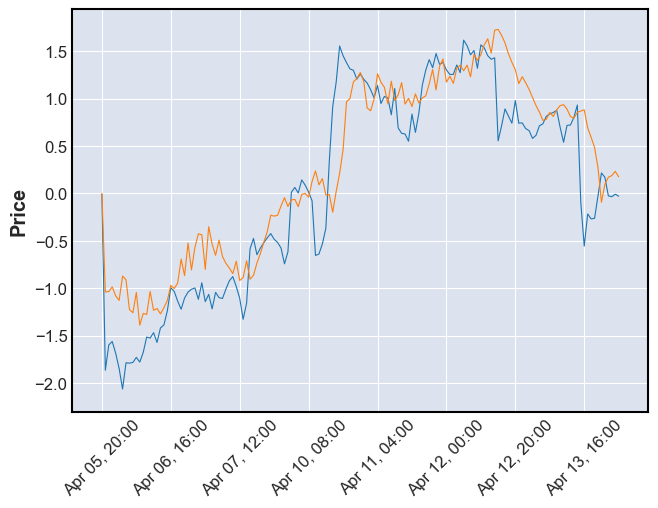

In [251]:
mc = mpl.make_marketcolors(up='green',down='red', edge='black')
s  = mpl.make_mpf_style(marketcolors=mc)

fig, axlist = mpl.plot(labels_df[['open','close','high','low']], #plotting the last 100 values since 5000 ticks are too much data.data[['open','close','high','low']][-100:]
                       type='line',
                       returnfig = True)
mpl.plot(predictions_df[['open','close','high','low']],
          type='line',
          ax=axlist[0],
          style = s)